<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/178/3classes/cross_validation_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install keras-metrics

In [3]:
! pip install -q scikit-plot

In [7]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [10]:
data_dir = "/content/drive/My Drive/Data/video_data"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 20

# Restaurant remove version
classes = ["DiningRoom","Office", "Restaurant", "Museum", "ChildsRoom"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1

    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
            
    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        print(c, ': ' , len(files_list))
        print(c ,' index number : ', classes.index(c) )
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                #print(y)
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  3


In [11]:
X, Y = create_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

Office
Office :  178
Office  index number :  1
Restaurant
Restaurant :  178
Restaurant  index number :  2
DiningRoom
DiningRoom :  178
DiningRoom  index number :  0


In [ ]:
print(X)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [12]:
def create_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.summary()

    # Various optimizer

    #opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = keras.optimizers.SGD(lr=0.001)
    #opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    #opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    #opt = keras.optimizers.Adagrad(lr=0.001, epsilon=1e-6)
    #opt = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
    return model

In [13]:
model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
results = cross_val_score(model, X, Y, cv=kfold)

print('Result of Cross Validation:')
print('cross validation accuracy:',np.round(results, 4))
print('mean accuracy:', np.round(np.mean(results), 4))
print('std :', np.round(np.std  (results), 4))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [14]:
from sklearn.model_selection import cross_val_predict

model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
predicted = cross_val_predict(model, X, Y, cv=kfold)

print('Cross validation prediction done!')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_9 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_12 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              


Classification report:
               precision    recall  f1-score   support

  DiningRoom       0.51      0.28      0.36       178
      Office       0.44      0.46      0.45       178
  Restaurant       0.47      0.65      0.54       178

    accuracy                           0.46       534
   macro avg       0.47      0.46      0.45       534
weighted avg       0.47      0.46      0.45       534

Confusion matrix: 

[[ 50  58  70]
 [ 34  82  62]
 [ 15  48 115]]


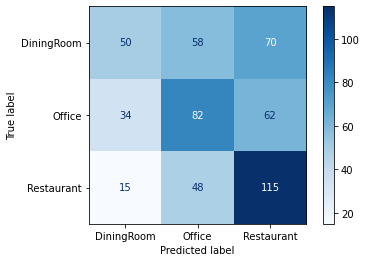

In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

rounded_Y=np.argmax(Y, axis=1)


# Classification report 
classes = ["DiningRoom","Office", "Restaurant"]

targets = ['DiningRoom','Office', 'Restaurant']
print('\nClassification report:\n',classification_report(rounded_Y, predicted, target_names=targets))


# Confusion Matrix
cm = confusion_matrix(rounded_Y, predicted) 
print('Confusion matrix: \n')
print(cm)

disp = ConfusionMatrixDisplay(cm,  display_labels=['DiningRoom','Office', 'Restaurant'])
disp.plot(cmap=plt.cm.Blues, values_format='')


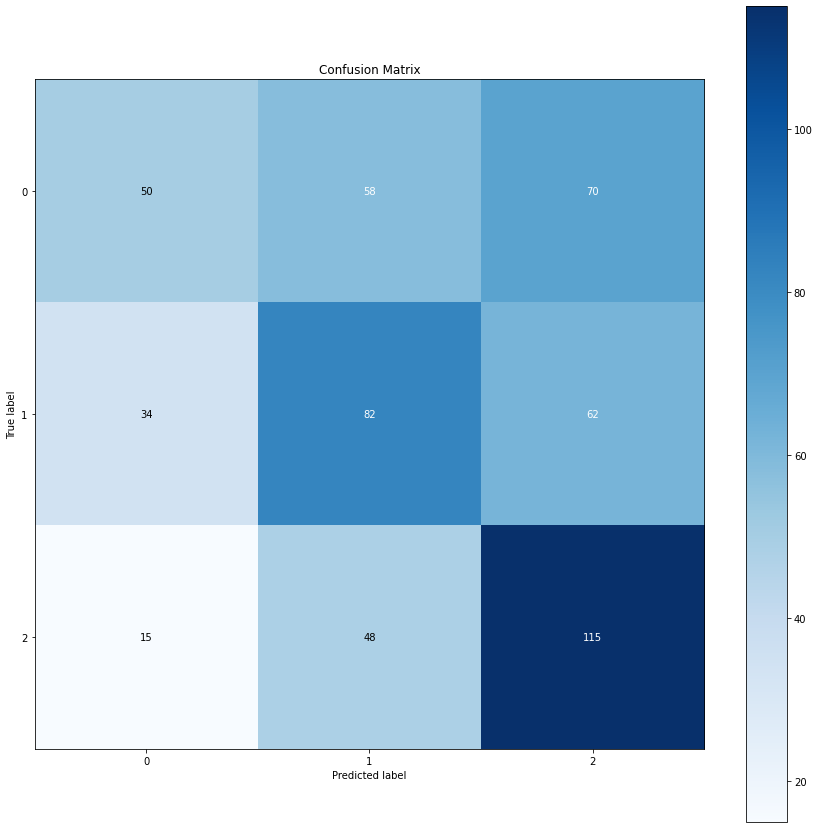

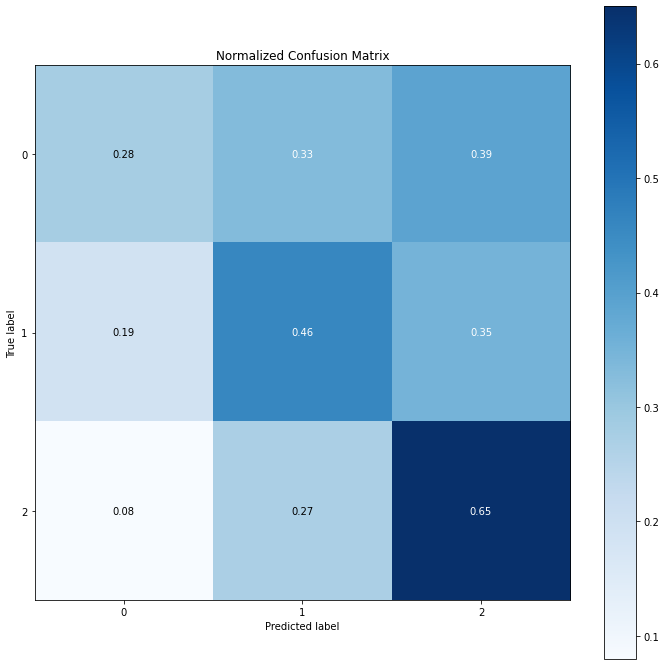

In [17]:
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix

skplt.metrics.plot_confusion_matrix(rounded_Y, predicted,  figsize=(15,15))
skplt.metrics.plot_confusion_matrix(rounded_Y, predicted, figsize=(12,12), normalize=True)